In [5]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Linear Regression to predict days until trending

In [6]:
df = pd.read_csv('../0_data/DEvideos.csv')

In [7]:
df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

# Add additional Data
df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']

df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,days_until_trending,ratings,likes_per_rating,ratings_per_view,comments_per_view
0,LgVi6y5QIjM,2017-11-14,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,inscope21,24,2017-11-13 17:08:49,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",252786,35885,230,...,https://i.ytimg.com/vi/LgVi6y5QIjM/default.jpg,False,False,False,Heute gibt es mal wieder ein neues Format... w...,1,36115,0.993631,0.142868,0.006088
1,Bayt7uQith4,2017-11-14,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,LUKE! Die Woche und ich,23,2017-11-12 22:30:01,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",797196,53576,302,...,https://i.ytimg.com/vi/Bayt7uQith4/default.jpg,False,False,False,Kinder ferngesteuert! Kinder lassen sich sooo ...,2,53878,0.994395,0.067584,0.001603
2,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97190,6146,...,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",1,103336,0.940524,0.042722,0.005252
3,AHtypnRk7JE,2017-11-14,Das Fermi-Paradoxon,100SekundenPhysik,27,2017-11-12 15:00:01,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",380247,31821,458,...,https://i.ytimg.com/vi/AHtypnRk7JE/default.jpg,False,False,False,►Alle Videos: http://bit.ly/1fa7Tw3\n\n\n✚Snap...,2,32279,0.985811,0.084890,0.005141
4,ZJ9We4bjcg0,2017-11-14,18 SONGS mit Kelly MissesVlog (Sing-off),rezo,24,2017-11-12 13:10:36,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",822213,100684,2467,...,https://i.ytimg.com/vi/ZJ9We4bjcg0/default.jpg,False,False,False,18 Song Mashup über den (veränderten) Beat von...,2,103151,0.976084,0.125455,0.012459


# Input of tag factor

In [8]:
tag_df = pd.read_csv('../0_data/DEtags.csv')
tag_df = tag_df.set_index('tag')
tag_df.head()

,factor,count
tag,,
full game,0.880435,23
split,0.862500,20
wellness,0.852273,22
neuer modus,0.843750,24
lcs,0.840909,22


## Converter function

In [9]:
def calculate_tag_factor(tag_string, tag_data):
    tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
    return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)

## Test function

In [10]:
df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)
df[['channel_title','tags','tag_factors']]


,channel_title,tags,tag_factors
0,inscope21,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",0.512928
1,LUKE! Die Woche und ich,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",0.612439
2,LastWeekTonight,"last week tonight trump presidency|""last week ...",0.686567
3,100SekundenPhysik,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",0.633594
4,rezo,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",0.541702
...,...,...,...
40835,Kingdom Hearts,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Pirat...",0.725610
40836,YourMovieSucksDOTorg,[none],0.000000
40837,Grünwald Freitagscomedy,"Günter Grünwald|""Grünwald Freitagscomedy""|""Gün...",0.661601
40838,Assassin's Creed DE,"Assassin's Creed|""Assassins Creed""|""Assassin's...",0.654359


# days_until_trending could be analyzed with views, likes, dislikes and comment_count

In [11]:
df.dtypes

video_id                          object
trending_date             datetime64[ns]
title                             object
channel_title                     object
category_id                        int64
publish_time              datetime64[ns]
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled                   bool
ratings_disabled                    bool
video_error_or_removed              bool
description                       object
days_until_trending                int64
ratings                            int64
likes_per_rating                 float64
ratings_per_view                 float64
comments_per_view                float64
tag_factors                      float64
dtype: object

# Split in Test- and Training values

In [12]:
x = pd.DataFrame(df['views'])
y = pd.DataFrame(df['days_until_trending'])

# x = preprocessing.scale(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
# train the model using the training set and calculate a score
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

-0.0005700736368008386

predicted response:
[[1.88192764]
 [1.90923311]
 [1.99056555]
 ...
 [1.87055565]
 [1.92638659]
 [1.88511466]]
intercept: 1.8692488844470858
slope: 5.0156078482959473e-08
coefficient of determination: 3.67639218979976e-05


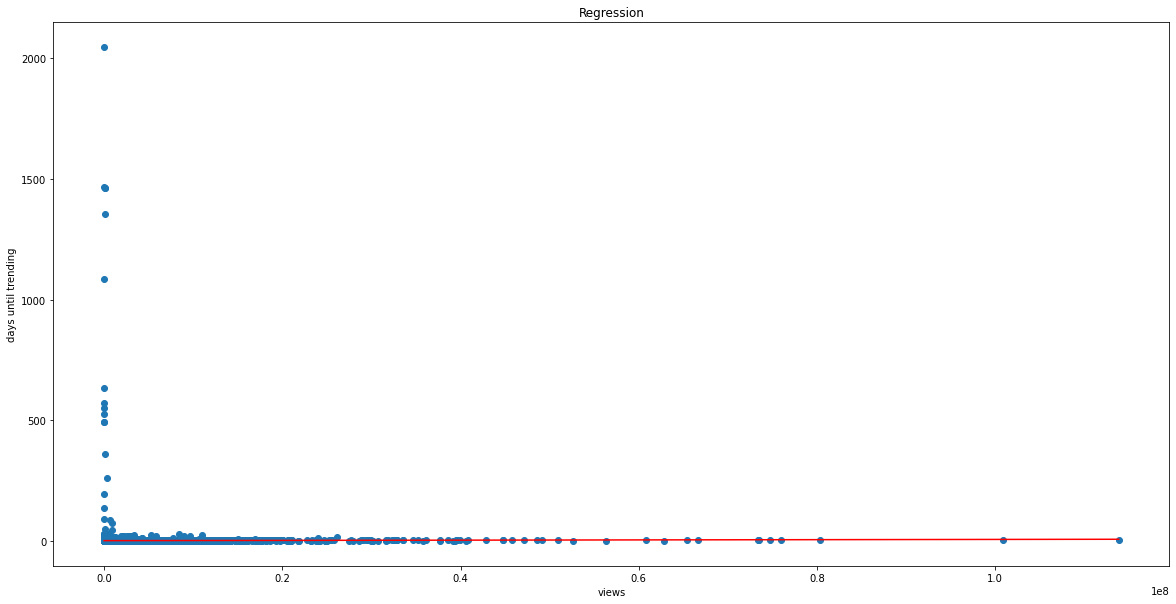

In [16]:
# Prediction of the values
y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')

intercept = model.intercept_[0]
slope = model.coef_[0, 0]
r_sq = model.score(x, y)
print('intercept:', intercept)
print('slope:', slope)
print('coefficient of determination:', r_sq)

# plot
plt.figure(figsize=(20, 10))
plt.title("Regression")
plt.xlabel("views")
plt.ylabel("days until trending")
plt.scatter(df.views, df.days_until_trending)
#plt.xlim(0, 900000)

#Plot regression grade
t = np.array([min(x.loc[:, "views"]), max(x.loc[:, "views"])])
t = t.reshape(-1, 1)
plt.plot(t, model.predict(t), "-r")

plt.show()

# Filter out some Data for a better result

In [ ]:
filter = len(df[df['days_until_trending'] > 6])

print(filter, "rows will be dropped")

rows = len(df.index)

print("That are", 100/rows*filter, "%")

# get names of indexes
index_names = df[ df['days_until_trending'] >= 6 ].index

# drop these row indexes from dataFrame
df.drop(index_names, inplace = True)

# Train and fit the model

In [ ]:
# use views, likes, dislikes and comment_count
x = df.iloc[:,7:11]
# only use views
#x = pd.DataFrame(df['views'])
y = pd.DataFrame(df['days_until_trending'])

x = preprocessing.scale(x)

# split again in training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
# train the model using the training set and calculate a score
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

## Data are not well spread
## Method is not applicable this way (see the plot)

In [ ]:
# plot
plt.figure(figsize=(20, 5))
plt.title("Regression")
plt.xlabel("views")
plt.ylabel("days until trending")
plt.scatter(df.views, df.days_until_trending)
